# To visualize small cutouts in Rubin and Euclid together

#### helpers and imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec

from scipy.optimize import linear_sum_assignment


def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)

def load_rubin_cutouts(ra, dec, size_arcsec, bands, repo="dp1", collection="LSSTComCam/DP1"):
    butler = Butler(repo, collections=collection) 
    pixscale = 0.2  # arcsec/pix for LSST coadd-like images (good enough for a visual check)
    n = int(np.round(size_arcsec / pixscale))
    if n % 2 == 1:
        n += 1

    out = {}
    for b in bands:
        refs = butler.query_datasets(
            "deep_coadd",
            where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
            bind={"band": b, "ra": ra, "dec": dec},
            with_dimension_records=True,
            order_by=["patch.tract"],
        )  # pattern used in the ECDFS notebook :contentReference[oaicite:2]{index=2}

        refs = list(refs)
        if not refs:
            out[b] = None
            continue

        dataId = refs[0].dataId
        wcs = butler.get("deep_coadd.wcs", dataId=dataId)  # :contentReference[oaicite:3]{index=3}
        sp = geom.SpherePoint(ra, dec, geom.degrees)
        xy = geom.PointI(wcs.skyToPixel(sp))

        bbox = geom.BoxI(xy - geom.ExtentI(n, n)//2, geom.ExtentI(n, n))
        cut = butler.get("deep_coadd", dataId=dataId, parameters={"bbox": bbox})  # :contentReference[oaicite:4]{index=4}

        out[b] = cut.image.array  # 2D numpy
    return out, wcs


def load_euclid_cutouts(ra, dec, size_arcsec, bands=("VIS","Y","J","H"),
                       collection="euclid_DpdMerBksMosaic", radius_arcsec=60):

    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")
    tab = Irsa.query_sia(pos=(coord, radius_arcsec*u.arcsec), collection=collection).to_table()
    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out, wcs_out = {b: None for b in bands}, {}

    for b in bands:
        rows = tab[tab["energy_bandpassname"] == b] if "energy_bandpassname" in tab.colnames else tab
        if len(rows) == 0:
            continue
        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                wcs0 = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec*u.arcsec, wcs=wcs0)
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs  # <- key fix

    return out, wcs_out





### Target

In [29]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 300.0
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]


### Plot

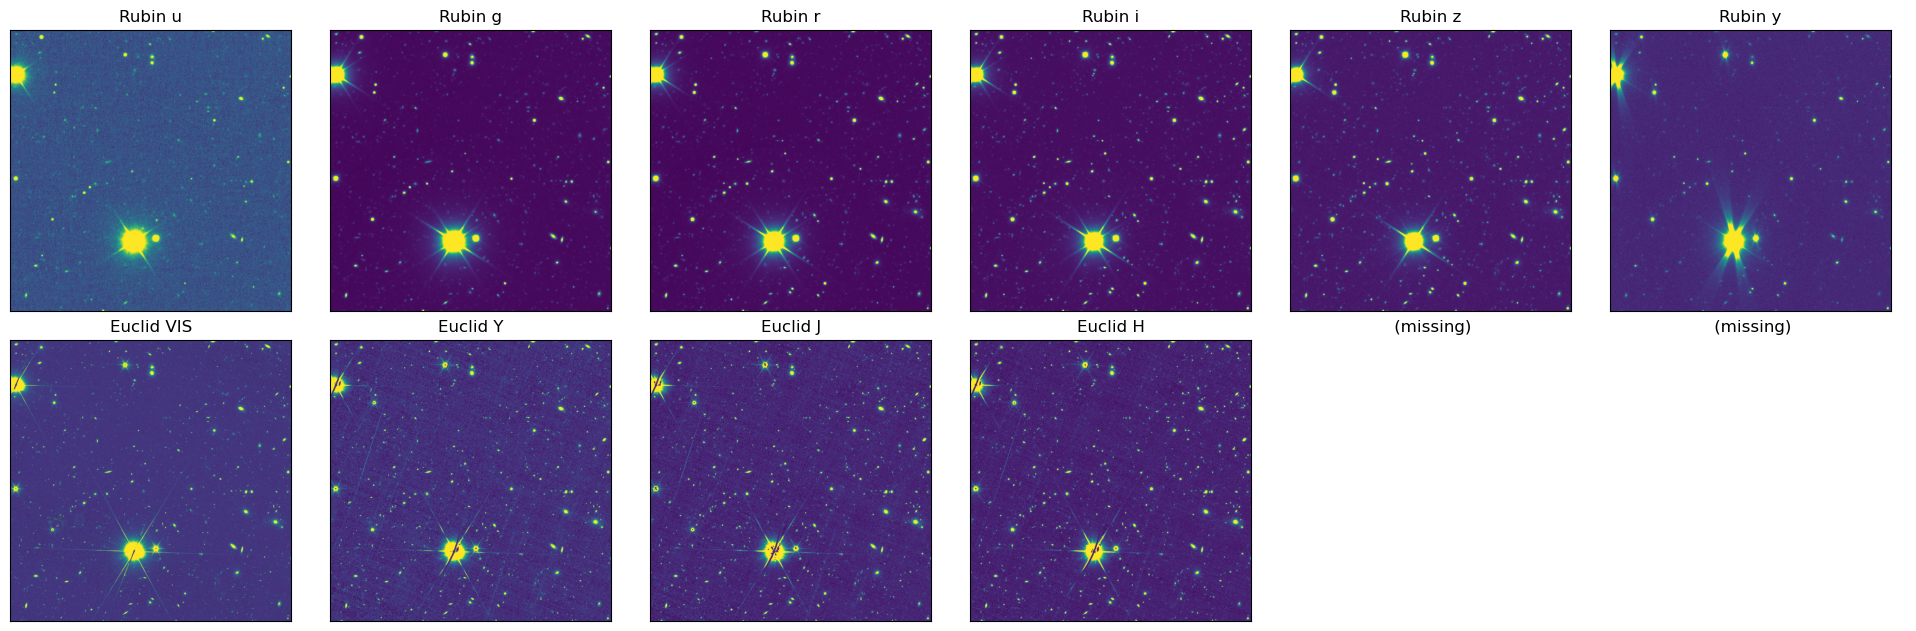

In [30]:
rub, rub_wcs = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

ncol = max(len(bands_rubin), len(bands_euclid))
fig, axes = plt.subplots(2, ncol, figsize=(3.2*ncol, 6.2), constrained_layout=True)

for j in range(ncol):
    ax = axes[0, j]
    b = bands_rubin[j] if j < len(bands_rubin) else ""
    robust_imshow(ax, rub.get(b), f"Rubin {b}" if b else "")

for j in range(ncol):
    ax = axes[1, j]
    b = bands_euclid[j] if j < len(bands_euclid) else ""
    robust_imshow(ax, euc.get(b), f"Euclid {b}" if b else "")

plt.show()


In [31]:

# ---------- peak finder (local maxima + robust threshold) ----------
def find_peaks(img, nsigma=10.0, border=10, top=200):
    m = np.nanmedian(img)
    s = 1.4826*np.nanmedian(np.abs(img-m))  # MAD -> sigma
    thr = m + nsigma*s
    a = np.nan_to_num(img, nan=-np.inf)

    c = a[1:-1,1:-1]
    neigh = [a[:-2,1:-1], a[2:,1:-1], a[1:-1,:-2], a[1:-1,2:],
             a[:-2,:-2], a[:-2,2:],  a[2:,:-2],   a[2:,2:]]
    locmax = np.logical_and.reduce([c >= n for n in neigh])
    mask = (c > thr) & locmax

    ys, xs = np.where(mask)
    ys, xs = ys+1, xs+1

    good = (xs>=border)&(xs<img.shape[1]-border)&(ys>=border)&(ys<img.shape[0]-border)
    xs, ys = xs[good], ys[good]

    if xs.size == 0:
        return np.array([]), np.array([])

    order = np.argsort(a[ys, xs])[::-1][:top]
    return xs[order].astype(float), ys[order].astype(float)

# ---------- pixel -> sky ----------
def pix_to_sky_rubin(skywcs, x, y):
    sp = skywcs.pixelToSky(geom.Point2D(float(x), float(y)))
    return (sp.getRa().asDegrees(), sp.getDec().asDegrees())

def pix_to_sky_astropy(wcs, x, y):
    ra, dec = wcs.all_pix2world([[float(x), float(y)]], 0)[0]
    return (ra, dec)

def skycoords_from_peaks(img, wcs, kind="rubin", nsigma=10, top=200, border=10):
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=top)
    if xs.size == 0:
        return SkyCoord([], [], unit="deg", frame="icrs")
    if kind == "rubin":
        radec = [pix_to_sky_rubin(wcs, x, y) for x, y in zip(xs, ys)]
    else:
        radec = [pix_to_sky_astropy(wcs, x, y) for x, y in zip(xs, ys)]
    ra = [r for r,d in radec]
    dec = [d for r,d in radec]
    return SkyCoord(ra*u.deg, dec*u.deg, frame="icrs")

# ---------- Hungarian one-to-one matching ----------
def hungarian_match(ref_sky, cand_sky, max_sep_arcsec=0.6):
    if len(ref_sky) == 0 or len(cand_sky) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    sep = ref_sky[:, None].separation(cand_sky[None, :]).to(u.arcsec).value
    cost = sep.copy()
    cost[cost > max_sep_arcsec] = 1e6  # gated

    r, c = linear_sum_assignment(cost)
    ok = cost[r, c] < 1e5
    return r[ok], c[ok], sep[r[ok], c[ok]]



In [32]:
# ---------- run: Rubin internal check ----------
ref_band = "i"
ref = skycoords_from_peaks(rub[ref_band], rub_wcs, kind="rubin", nsigma=10, top=60)

for b in ["g","r","i","z"]:
    cand = skycoords_from_peaks(rub[b], rub_wcs, kind="rubin", nsigma=10, top=200)
    ri, ci, sep_arcsec = hungarian_match(ref, cand, max_sep_arcsec=0.6)
    print(f"Rubin {b}: matches={len(sep_arcsec):3d}  median={np.median(sep_arcsec) if len(sep_arcsec) else np.nan:.4f} arcsec")


Rubin g: matches= 37  median=0.2828 arcsec
Rubin r: matches= 15  median=0.2827 arcsec
Rubin i: matches= 60  median=0.0000 arcsec
Rubin z: matches= 46  median=0.2827 arcsec


In [33]:
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

h2,w2 = euc["VIS"].shape
ra_e, dec_e = pix_to_sky_astropy(euc_wcs["VIS"], w2/2, h2/2)
# compare to Rubin center as before


In [34]:
print("Rubin center (deg):", ra_r, dec_r)
print("Euclid center (deg):", ra_e, dec_e)
print("Center separation (arcsec):", c_r.separation(c_e).to(u.arcsec).value)


Rubin center (deg): 53.98657168837282 -28.309276920255652
Euclid center (deg): 53.159985919702365 -28.099974669939424
Center separation (arcsec): 2379.468193588503


In [26]:
ref = skycoords_from_peaks(rub["i"], rub_wcs, kind="rubin", nsigma=10, top=60)
evis = skycoords_from_peaks(euc["VIS"], euc_wcs, kind="astropy", nsigma=10, top=400)
print("N peaks: Rubin i =", len(ref), " Euclid VIS =", len(evis))


N peaks: Rubin i = 60  Euclid VIS = 400


In [27]:
h,w = rub["i"].shape
ra_r, dec_r = pix_to_sky_rubin(rub_wcs, w/2, h/2)

h2,w2 = euc["VIS"].shape
ra_e, dec_e = pix_to_sky_astropy(euc_wcs, w2/2, h2/2)

c_r = SkyCoord(ra_r*u.deg, dec_r*u.deg)
c_e = SkyCoord(ra_e*u.deg, dec_e*u.deg)
print("center sep (arcsec):", c_r.separation(c_e).to(u.arcsec).value)


center sep (arcsec): 2379.468193588503
